In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Loading data...
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:

category_to_fill_with_none = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
for col in category_to_fill_with_none:
    train_data[col] = train_data[col].fillna("None")
    test_data[col] = test_data[col].fillna("None")


category_to_fill_with_mode = ["Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType", "Functional"]
mode = train_data[col].mode()[0]
for col in category_to_fill_with_mode:
    train_data[col] = train_data[col].fillna(mode)
    test_data[col] = test_data[col].fillna(mode)


numericals_to_fill_with_zero = ["GarageYrBlt", "MasVnrArea"]
for col in numericals_to_fill_with_zero:
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)

# The other missing numeric values except SalePrice filled with the median of that column
numeric_columns = train_data.select_dtypes(include=["number"]).columns.drop("SalePrice", errors="ignore")
for col in numeric_columns:
    train_data[col] = train_data[col].fillna(train_data[col].median())
    test_data[col] = test_data[col].fillna(test_data[col].median())


In [ ]:
# I made AgeofHouse  and Total Square Footage my  New Features
train_data["HouseAge"] = train_data["YrSold"] - train_data["YearBuilt"]
test_data["HouseAge"] = test_data["YrSold"] - test_data["YearBuilt"]

train_data["TotalSF"] = train_data["TotalBsmtSF"] + train_data["1stFlrSF"] + train_data["2ndFlrSF"]
test_data["TotalSF"] = test_data["TotalBsmtSF"] + test_data["1stFlrSF"] + test_data["2ndFlrSF"]


In [ ]:
# Choosing features I will use
X = train_data.drop(columns=["Id", "SalePrice"])
y = train_data["SalePrice"] # target variable

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-Hot Encoding for categorical data
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
encoder = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)], remainder="passthrough")

# encoding...
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [ ]:
# Initialize models
linear_model = LinearRegression()
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

#  the models
linear_model.fit(X_train_encoded, y_train)
decision_tree.fit(X_train_encoded, y_train)
random_forest.fit(X_train_encoded, y_train)

print("successfully trained models")


All models have been successfully trained!



Linear Regression Performance:
Mean Absolute Error (MAE): 20621.75
Mean Squared Error (MSE): 981377759.27
Root Mean Squared Error (RMSE): 31326.95
R-Squared (R²): 0.87

Decision Tree Performance:
Mean Absolute Error (MAE): 27582.00
Mean Squared Error (MSE): 1830219515.85
Root Mean Squared Error (RMSE): 42781.06
R-Squared (R²): 0.76

Random Forest Performance:
Mean Absolute Error (MAE): 17929.75
Mean Squared Error (MSE): 892259584.29
Root Mean Squared Error (RMSE): 29870.71
R-Squared (R²): 0.88


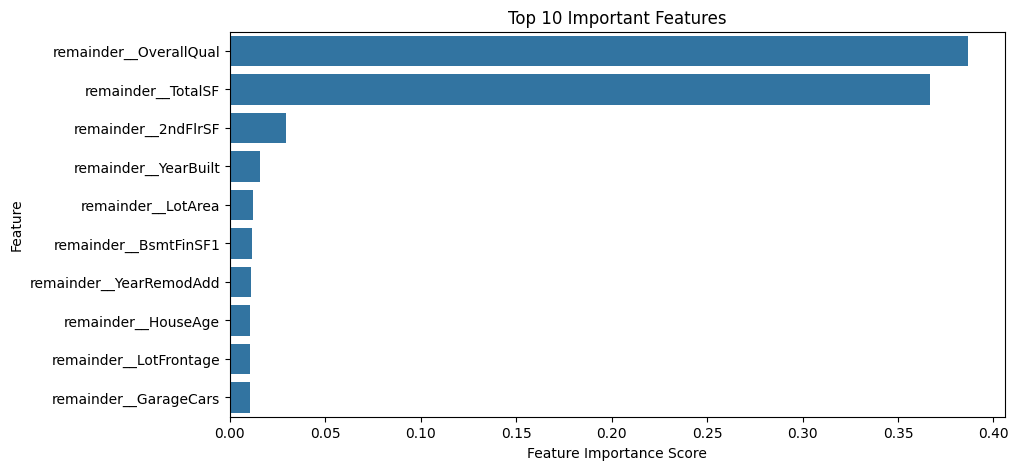

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction)
    
    print(f"\n{model_name} Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-Squared (R²): {r2:.2f}")

# Evaluating models....
evaluate_model(linear_model, X_test_encoded, y_test, "Linear Regression")
evaluate_model(decision_tree, X_test_encoded, y_test, "Decision Tree")
evaluate_model(random_forest, X_test_encoded, y_test, "Random Forest")

# Feature importance for the best model (Random Forest)
best_model = random_forest  # Assuming Random Forest performs best
feature_names = encoder.get_feature_names_out()

# Get feature importance and sort them
importances = best_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=importances[sorted_indices][:10], y=feature_names[sorted_indices][:10])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features")
plt.show()

## Interpretation of Feature Importance

From the feature importance graph, we can see that **Overall Quality (`OverallQual`)** and **Total Square Footage (`TotalSF`)** are the most important factors in predicting house prices. This makes sense because:
- **OverallQual** describes how good the materials and finishes in the house are. Better quality means a higher price.
- **TotalSF** tells us how big the house is. Bigger houses usually cost more.

---

## Model Performance Comparison

### 1. Linear Regression
- **R²:** **0.87** → The model explains **87%** of the changes in house prices.
- **RMSE:** **31,326** → The average prediction error is about **$31K**.
- **Good accuracy**, but it might not handle complex patterns well.

### 2. Decision Tree
- **R²:** **0.76** → It explains **76%** of the price changes.
- **RMSE:** **42,781** → Errors are larger compared to Linear Regression.
- **Overfits the data**, meaning it learns details too well but struggles with new data.

### 3. Random Forest (Best Model)
- **R²:** **0.88** → It explains **88%** of house price variations.
- **RMSE:** **29,870** → It has the lowest error, meaning better predictions.
- **Best model overall**, as it captures important patterns and avoids overfitting.

---

## Real-World Meaning
- **Higher quality homes and bigger houses cost more**, which matches real-life real estate trends.
- **Newer houses and renovated homes sell for higher prices**, as expected.
- **Lot size matters, but not as much as quality and space**

### Conclusion
The **Random Forest model** is the best choice here. It predicts prices more accurately while avoiding common mistakes like overfitting. 
